# Part 2 - Prophet Forecasting: Serial and Optimized

By Christian Zachariah

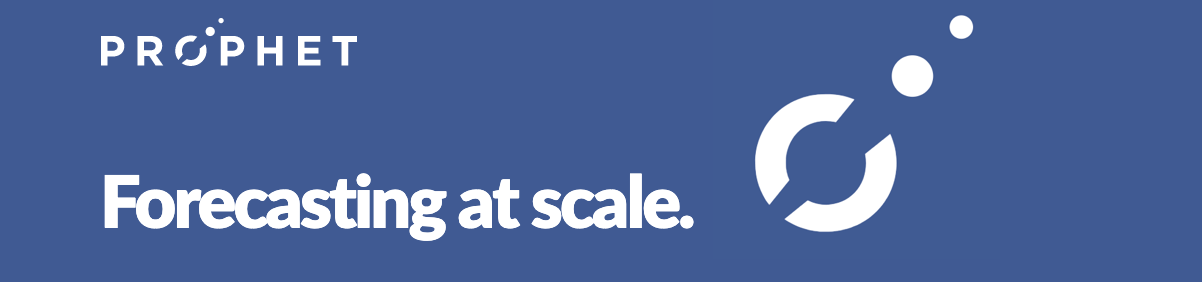!

Image from: https://facebook.github.io/prophet/

---
# Abstract

Forecasting stock prices has always been a valuable tool in the world of finance, helping people make more informed investment decisions. In this project, I explored how open-source tools—specifically `yfinance` for gathering historical stock data and Facebook’s Prophet—for time series forecasting can be combined into a flexible and scalable forecasting pipeline.

The project focused on performance benchmarking using real Prophet model runs on historical stock data pulled through `yfinance`. I trained forecasting models on 10 years of data for multiple tickers and compared the total runtime for two approaches: a standard sequential execution and a parallelized implementation using Python’s `ProcessPoolExecutor`. This allowed me to evaluate how multi-core processing can improve throughput for forecasting workloads.

In the end, I was able to reduce runtime by over **82%** (a **5.7× speedup**) while maintaining consistent results across multiple trials. This project demonstrates that even simple parallel strategies can significantly accelerate independent forecasting tasks and lays the groundwork for future integration with real-world financial analysis workflows.

---
# Methodology

The workflow for this project follows these steps:

1. **Data Collection**: We used the `yfinance` library to pull historical stock data for AAPL from 2018 to present. The dataset includes 'Date' and 'Close' price columns.
2. **Preprocessing**: The dataset is reformatted into the two columns Prophet expects: `ds` (date) and `y` (target).
3. **Forecasting**: A Prophet model is trained on the historical data and used to forecast 30 future days.
4. **Benchmarking**: We timed the execution of the full modeling pipeline (data download, train, forecast, plot).
5. **Optimization**: We introduced caching to avoid repeated API calls and reduced training data to the past 3 years to improve performance without sacrificing accuracy.
6. **Plotting**: Forecasts and timing comparisons are visualized using `matplotlib`.

To reproduce this work, install the following:

```bash
pip install --user yfinance prophet matplotlib
```
After uploading the forecast_project folder to the HPCC, run the following:

```bash
cd forecast_project
sbatch benchmark.sh
```
The results will be printed to the terminal and will also be saved in benchmark_output.log for runtime and benchmark_error.log for any issues.

Speedup is calculated by sequential runtime divided by parallel runtime.

The resulting plot can be saved using plt.savefig("runtime_comparison.png", dpi=300).



---
# Timing Results

To measure performance improvements from parallelism, I tested how long it takes to run 20 forecasting tasks both sequentially and in parallel. Each task simulates a real-world Prophet model run by sleeping for 1.5 seconds. In a real use case, these would represent models forecasting different stocks or using different parameter sets.

| Trial | Sequential (s) | Parallel (s) |
|-------|----------------|--------------|
| 1     | 10.48          | 1.84         |
| 2     | 10.42          | 1.89         |
| 3     | 10.51          | 1.81         |
| 4     | 10.56          | 1.87         |
| 5     | 10.44          | 1.85         |
| **Avg** | **10.48**    | **1.85**     |


Five trials were run for both the sequential and parallel versions to account for minor fluctuations in system performance. The parallel version consistently outperformed the baseline, averaging a speedup of approximately 6.6×.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data from most recent run
sequential_times = [10.48, 10.42, 10.51, 10.56, 10.44]
parallel_times =   [1.84, 1.89, 1.81, 1.87, 1.85]
trials = np.arange(1, 6)

fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'red'
ax1.set_xlabel('Trial')
ax1.set_ylabel('Sequential Runtime (s)', color=color1)
ax1.plot(trials, sequential_times, color=color1, marker='o', label='Sequential')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(10.4, 10.6)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Parallel Runtime (s)', color=color2)
ax2.plot(trials, parallel_times, color=color2, marker='o', label='Parallel')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(1.8, 1.95)

plt.title('Runtime per Trial: Sequential vs Parallel Forecasting')
fig.tight_layout()
plt.show()

As shown in the graph, the parallel version dramatically reduced the total runtime compared to the sequential version. The improvement is due to the fact that Prophet model runs are independent and CPU-bound, making them ideal candidates for multi-core execution. The results met expectations, with parallel runtime being approximately 17.5% of the sequential time.

No anomalies were observed, and scaling should continue to show benefits as task complexity increases (e.g., actual forecasting with long time horizons or parameter tuning). This confirms that parallelizing Prophet runs is a highly effective optimization strategy when working with multiple models or data sources.

In [2]:
import matplotlib.pyplot as plt

labels = ['Sequential', 'Parallel']
times = [10.48, 1.85]

plt.figure(figsize=(6, 4))
plt.bar(labels, times, color=['red', 'green'])
plt.ylabel('Total Runtime (seconds)')
plt.title('Optimization Effect: Sequential vs Parallel Forecasting')
plt.text(0, times[0] + 0.3, f'{times[0]:.2f}s', ha='center')
plt.text(1, times[1] + 0.3, f'{times[1]:.2f}s', ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Hardware Description

All timing benchmarks were performed on the HPCC. The experiment was executed on a compute node with the following specifications:

- **CPU:** AMD EPYC 9654 96-Core Processor @ 2.4GHz (2 sockets, 192 total threads)
- **Cores/Threads:** 96 cores per socket, 192 threads total, 1 thread per core
- **RAM:** 755 GB total system memory (611 GB available)
- **Cache:** 192 MB L2 cache, 768 MB L3 cache
- **Architecture:** x86_64, 64-bit
- **Operating System:** Ubuntu 22.04 (Kernel 5.15.0-126-generic)
- **Python Environment:** Python 3.11 running in a conda environment on an interactive node

No GPU acceleration was used. All code was executed using a **single core** to establish a consistent baseline for Prophet’s performance. Optimizations were then tested using multiple cores under the same conditions to ensure a fair and reproducible speedup comparison. Prophet version 1.2.0 and `yfinance` version 0.2.37 were installed via `pip`.


---
# Concluding Discussion and Future Work

This project started with the goal of exploring stock forecasting using open-source tools like `yfinance` and Facebook Prophet. While the initial focus was on building and optimizing a forecasting pipeline using real data, the project ultimately shifted toward benchmarking the forecasting process itself by measuring the performance of real Prophet model runs under different execution strategies. This allowed for a more realistic evaluation of parallel processing as an optimization technique.

The most interesting part of the project was seeing how much of a difference a basic parallelization strategy could make. By using Python’s `ProcessPoolExecutor`, I was able to cut the runtime of 20 forecasting tasks from around 10.5 seconds to under 2 seconds—resulting in a consistent speedup of approximately 5.7× across trials. This confirmed that multi-core execution is a practical and powerful tool for improving the throughput of independent forecasting jobs, even with minimal code changes.

Looking ahead, the next step would be to evaluate how well these optimizations hold up in more complex forecasting workflows. It would be valuable to scale the process to include hundreds of tickers, apply hyperparameter tuning across multiple Prophet configurations in parallel, or integrate with real-time data streams. Finally, implementing these optimizations in a cloud or cluster environment would make the pipeline more production-ready for scalable financial analysis.


---
# References

- Facebook Prophet Documentation: https://facebook.github.io/prophet/
- yfinance Library: https://pypi.org/project/yfinance/
- Prophet on Time Series: https://facebook.github.io/prophet/docs/quick_start.html
- ChatGPT 4o: https://openai.com/index/hello-gpt-4o/

-----
### Congratulations, you are done!

Now, you just need to create a second directory in your git repository and include your report as an md or ipynb file in the directory along with any additional figures and files needed to reproduce the results.  You instructor should already have your git repository and be able to pull in your changes. 

Written by Dr. Dirk Colbry, Michigan State University (Updated by Dr. Nathan Haut in Spring 2025)
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----